In [17]:
!where.exe python

C:\Users\dev\PycharmProjects\movielens-recommender\venv\Scripts\python.exe
C:\Users\dev\AppData\Local\Microsoft\WindowsApps\python.exe


In [18]:
!.\venv\Scripts\pip3.exe install -r requirements.txt


[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


# Import libraries

In [51]:
import os
from datetime import datetime

import pandas as pd
import matplotlib.pyplot as plt
from fastai.callback.tracker import EarlyStoppingCallback
from fastai.collab import CollabDataLoaders, collab_learner, TabularCollab
from fastai.data.block import TransformBlock
from fastai.data.transforms import RandomSplitter
from fastai.learner import load_learner
from fastai.tabular.core import Categorify
from fastcore.basics import range_of
import numpy as np
from torch import tensor
import seaborn as sns

# Load data

In [57]:
df_ratings = pd.read_csv('data/ratings.csv')
df_movies = pd.read_csv('data/movies.csv')
df_tags = pd.read_csv('data/tags.csv')

# Prepare data

In [58]:
df_ratings = df_ratings.drop(columns=['timestamp'])
df_tags = df_tags.drop(columns=['timestamp'])

In [59]:
# one hot encode movie genres
genre_dummies = df_movies['genres'].str.get_dummies(sep='|')
df_movies = pd.concat([df_movies, genre_dummies], axis=1)
df_movies.head()

,movieId,title,genres,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,0,0,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji (1995),Adventure|Children|Fantasy,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),Comedy|Romance,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
4,5,Father of the Bride Part II (1995),Comedy,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [67]:
# turn years from the title into columns
df_movies['year'] = df_movies['title'].str.extract(r'\((\d{4})\)')
df_movies['year'] = pd.to_numeric(df_movies['year'], errors='coerce')
df_movies['year'] = df_movies['year'].fillna(0).astype(int)
df_movies.head()

,movieId,title,genres,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,...,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,year
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,0,0,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,1995
1,2,Jumanji (1995),Adventure|Children|Fantasy,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1995
2,3,Grumpier Old Men (1995),Comedy|Romance,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,1995
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,1995
4,5,Father of the Bride Part II (1995),Comedy,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1995


In [60]:
df_ratings = df_ratings.merge(df_movies, on='movieId')
df_ratings.head()

,userId,movieId,rating,title,genres,(no genres listed),Action,Adventure,Animation,Children,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,296,5.0,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,3,296,5.0,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,4,296,4.0,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,5,296,4.0,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,7,296,4.0,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


# Analyze rating data

## main dataset stats

In [5]:
df_ratings.head()

,userId,movieId,rating,title,genres
0,1,296,5.0,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller
1,3,296,5.0,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller
2,4,296,4.0,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller
3,5,296,4.0,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller
4,7,296,4.0,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller


In [6]:
df_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000095 entries, 0 to 25000094
Data columns (total 5 columns):
 #   Column   Dtype  
---  ------   -----  
 0   userId   int64  
 1   movieId  int64  
 2   rating   float64
 3   title    object 
 4   genres   object 
dtypes: float64(1), int64(2), object(2)
memory usage: 953.7+ MB


In [8]:
df_ratings.shape

(25000095, 5)

In [9]:
df_ratings['rating'].describe()

count    2.500010e+07
mean     3.533854e+00
std      1.060744e+00
min      5.000000e-01
25%      3.000000e+00
50%      3.500000e+00
75%      4.000000e+00
max      5.000000e+00
Name: rating, dtype: float64

<Axes: >

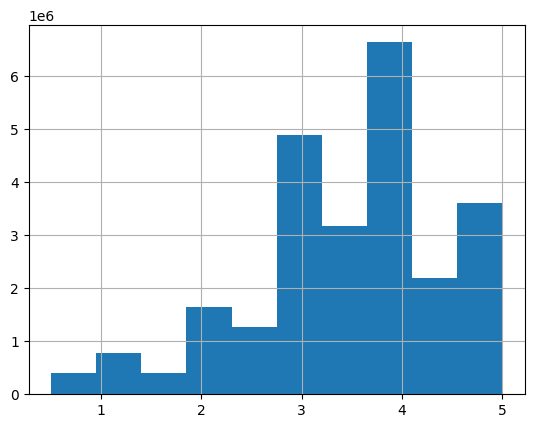

In [10]:
df_ratings['rating'].hist()

In [11]:
df_ratings['rating'].value_counts()

rating
4.0    6639798
3.0    4896928
5.0    3612474
3.5    3177318
4.5    2200539
2.0    1640868
2.5    1262797
1.0     776815
1.5     399490
0.5     393068
Name: count, dtype: int64

In [68]:
df_movies.shape

(62423, 24)

In [71]:
df_movies[df_movies['year'] != 0]['year'].describe()

count    62013.000000
mean      1992.044700
std         25.364884
min       1874.000000
25%       1976.000000
50%       2002.000000
75%       2012.000000
max       2019.000000
Name: year, dtype: float64

In [12]:
df_ratings['rating'].value_counts(normalize=True)

rating
4.0    0.265591
3.0    0.195876
5.0    0.144498
3.5    0.127092
4.5    0.088021
2.0    0.065634
2.5    0.050512
1.0    0.031072
1.5    0.015980
0.5    0.015723
Name: proportion, dtype: float64

<Axes: xlabel='rating'>

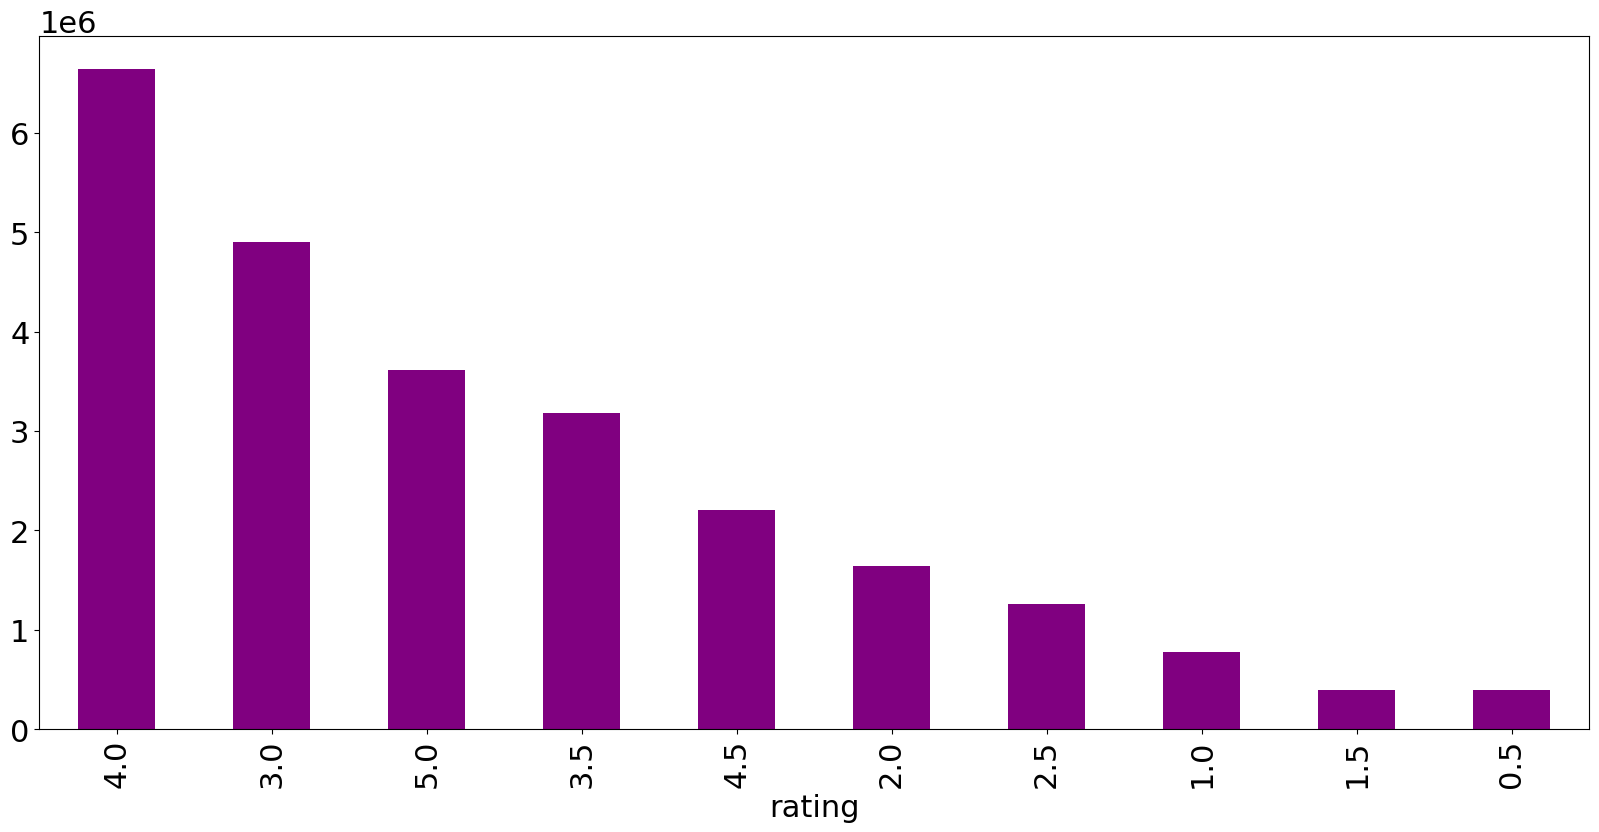

In [21]:
plt.rcParams['figure.figsize'] = [20, 9]
plt.rcParams.update({'font.size': 22})
df_ratings['rating'].value_counts().plot(kind='bar', color='purple')

## user count for each rating count

<Axes: xlabel='rating'>

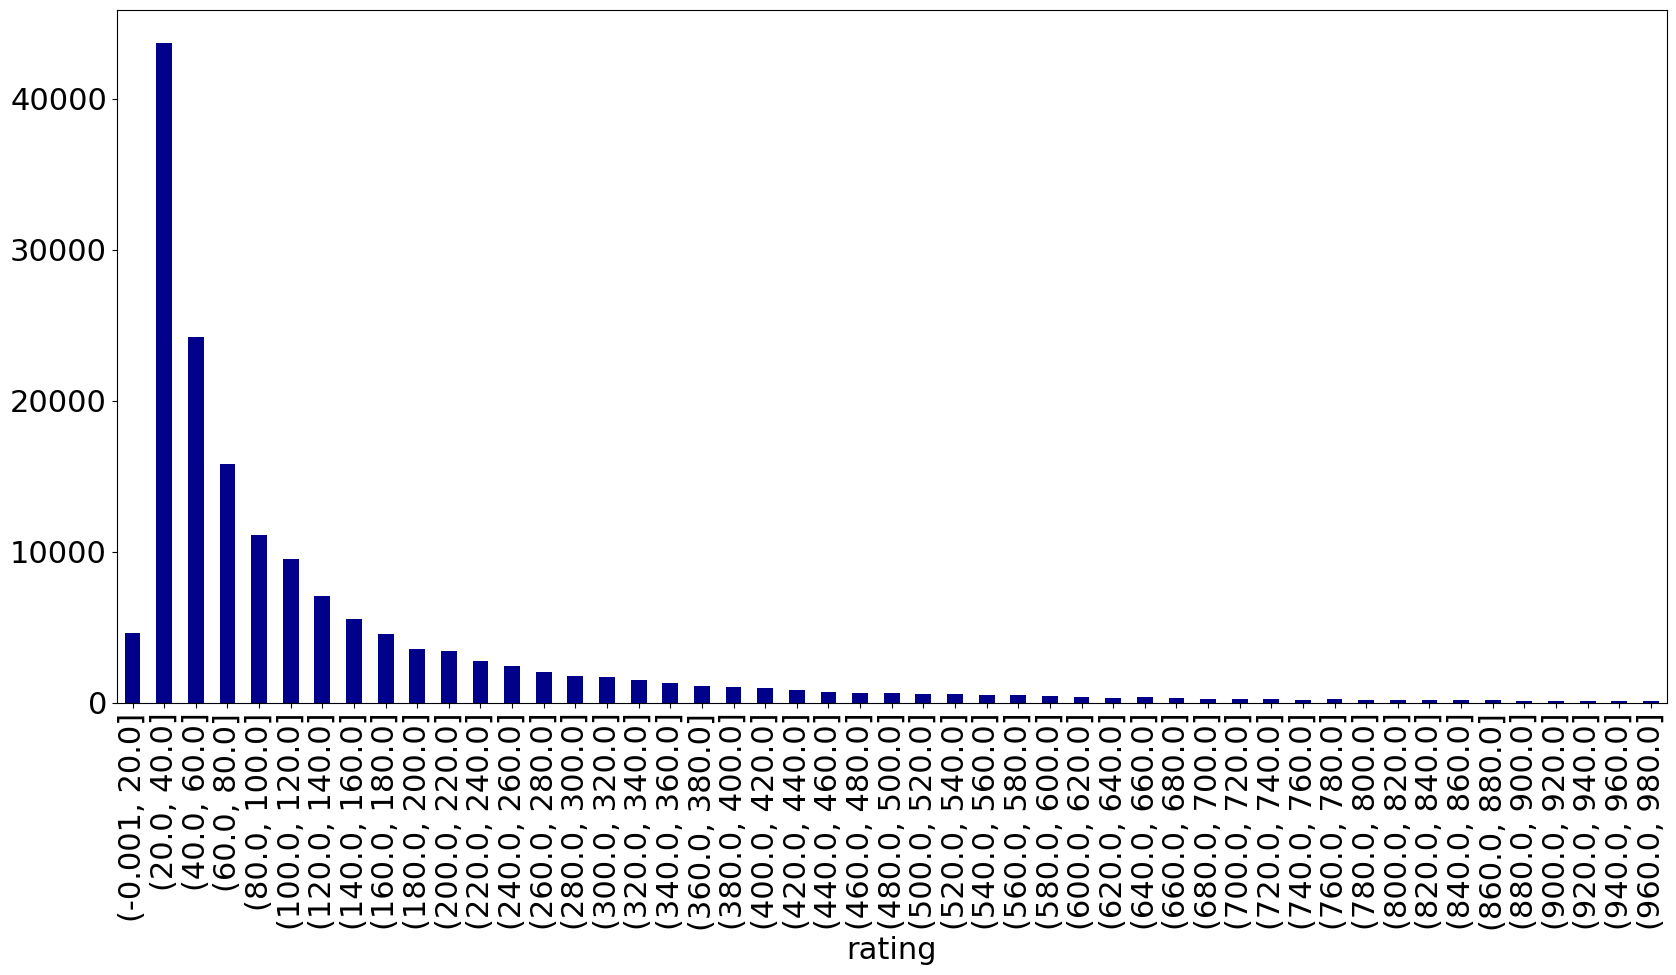

In [22]:
# set plot size
plt.rcParams['figure.figsize'] = [20, 9]
plt.rcParams.update({'font.size': 22})

rate_counts = df_ratings.groupby('userId')['rating'].count()
rate_counts = pd.cut(rate_counts, bins=range(0, 1000, 20), include_lowest=True)
rate_counts = rate_counts.value_counts()
# split into bins
rate_counts = rate_counts.sort_index()
# plot
rate_counts.plot(kind='bar', color='darkblue')

# Analyze movie genres

In [23]:
df_movies.shape

(62423, 23)

In [73]:
df_tags['tag'].value_counts()

tag
sci-fi              8330
atmospheric         6516
action              5907
comedy              5702
surreal             5326
                    ... 
teen sleuth            1
evil twins             1
paternity test         1
QVC                    1
cornetto triolgy       1
Name: count, Length: 73050, dtype: int64

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]),
 [Text(0, 0, 'Drama'),
  Text(1, 0, 'Comedy'),
  Text(2, 0, 'Thriller'),
  Text(3, 0, 'Romance'),
  Text(4, 0, 'Action'),
  Text(5, 0, 'Horror'),
  Text(6, 0, 'Documentary'),
  Text(7, 0, 'Crime'),
  Text(8, 0, '(no genres listed)'),
  Text(9, 0, 'Adventure'),
  Text(10, 0, 'Sci-Fi'),
  Text(11, 0, 'Children'),
  Text(12, 0, 'Animation'),
  Text(13, 0, 'Mystery'),
  Text(14, 0, 'Fantasy'),
  Text(15, 0, 'War'),
  Text(16, 0, 'Western'),
  Text(17, 0, 'Musical'),
  Text(18, 0, 'Film-Noir'),
  Text(19, 0, 'IMAX')])

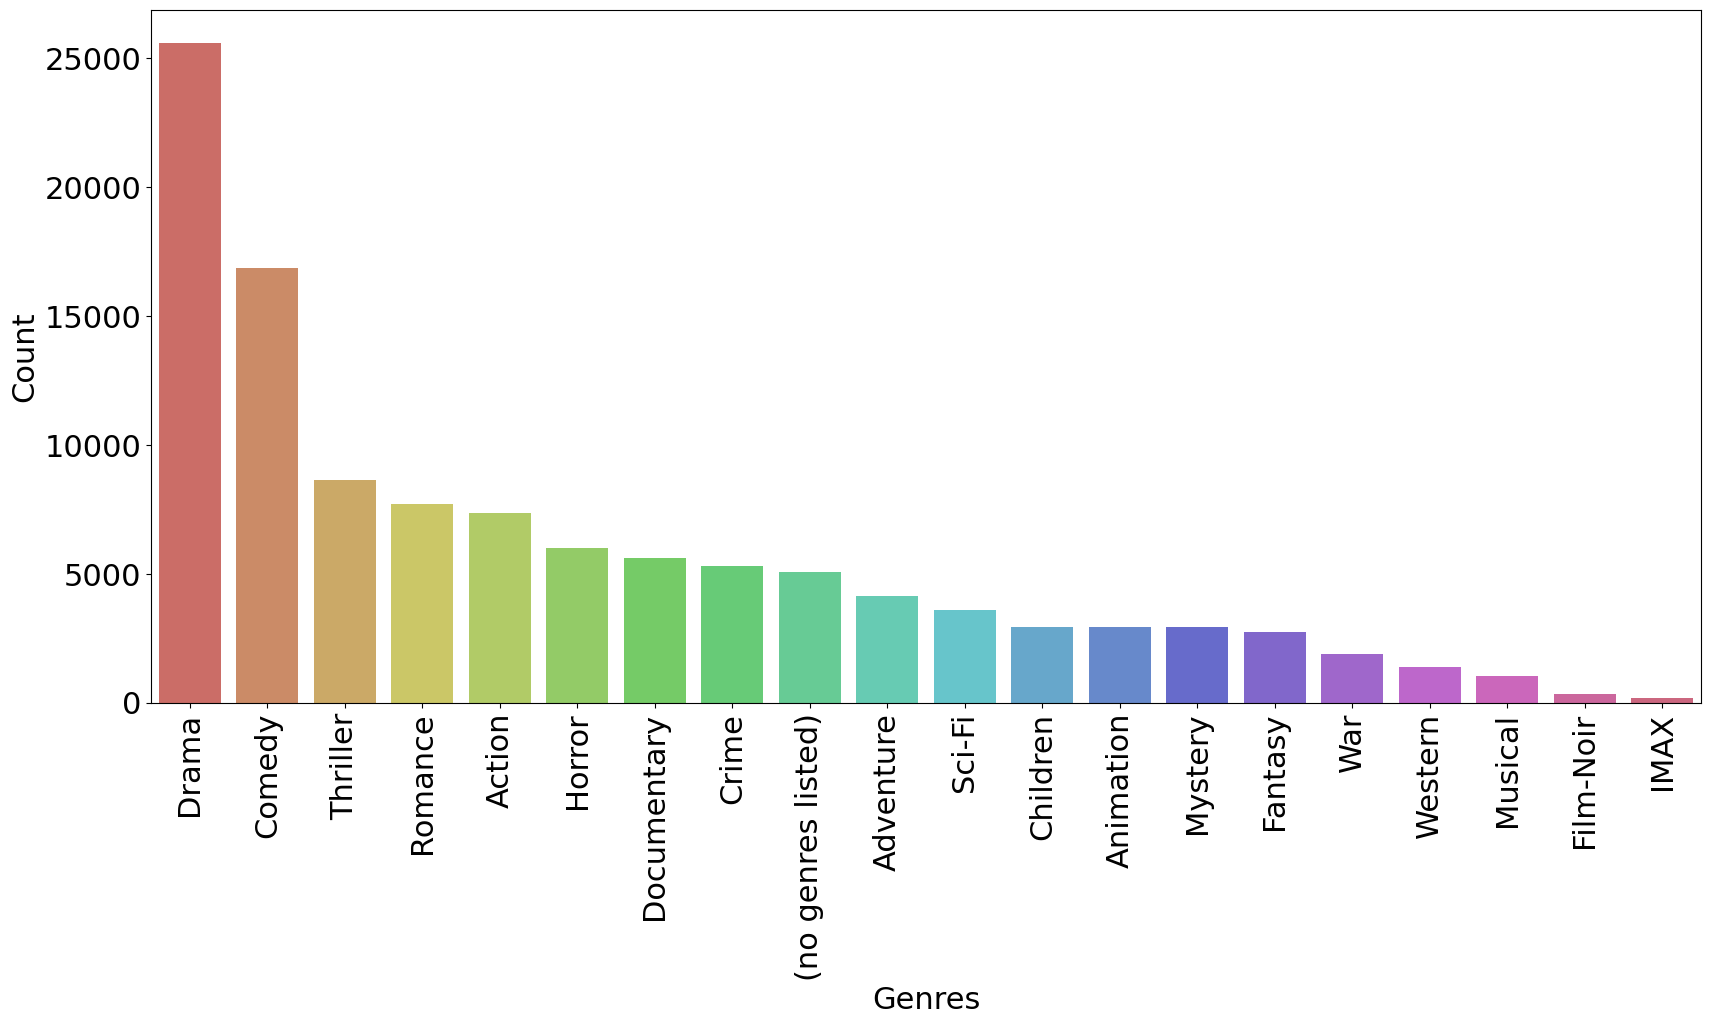

In [54]:
# plot count of movies in each genre
plt.rcParams['figure.figsize'] = [20, 9]
plt.rcParams.update({'font.size': 22})
genre_counts = df_movies.iloc[:, 3:].sum()
genre_counts = genre_counts.sort_values(ascending=False)
# plot with different colors for each genre
sns.barplot(
    x=genre_counts.index,
    y=genre_counts.values,
    palette=sns.color_palette('hls', len(genre_counts)),
)
# set x axis title
plt.xlabel('Genres')
# set y axis title
plt.ylabel('Count')
# rotate x axis labels
plt.xticks(rotation=90)

In [65]:
df_ratings.loc[:, '(no genres listed)':].head()

,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,1,0,0
1,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,1,0,0
2,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,1,0,0
3,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,1,0,0
4,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,1,0,0


In [66]:
# plot average rating for each genre
plt.rcParams['figure.figsize'] = [20, 9]
plt.rcParams.update({'font.size': 22})
genre_ratings = df_ratings.loc[:, '(no genres listed)':].mul(df_ratings['rating'], axis=0)
genre_ratings = genre_ratings.sum() / genre_counts
genre_ratings = genre_ratings.sort_values(ascending=False)
# plot with different colors for each genre
sns.barplot(
    x=genre_ratings.index,
    y=genre_ratings.values,
    palette=sns.color_palette('hls', len(genre_ratings)),
)
# set x axis title
plt.xlabel('Genres')
# set y axis title
plt.ylabel('Average rating')
# rotate x axis labels
plt.xticks(rotation=90)

MemoryError: Unable to allocate 3.73 GiB for an array with shape (20, 25000095) and data type float64

In [39]:
df_movies.iloc[:, 3:].head(20)

,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Finding optimal factor count

[0, 2.2494099140167236, 2.0620222091674805, '00:01']
[1, 1.892295241355896, 1.515490174293518, '00:01']
[2, 1.5363426208496094, 1.2315468788146973, '00:01']
[3, 1.2921735048294067, 1.1335026025772095, '00:01']
[4, 1.1607697010040283, 1.119118332862854, '00:01']


[0, 2.2424118518829346, 2.0573322772979736, '00:01']
[1, 1.8682562112808228, 1.4346187114715576, '00:01']
[2, 1.4257103204727173, 1.0678640604019165, '00:01']
[3, 1.1165251731872559, 0.9749892354011536, '00:01']
[4, 0.9546719789505005, 0.9636189937591553, '00:01']


[0, 2.2511818408966064, 2.0626699924468994, '00:01']
[1, 1.851646900177002, 1.3605315685272217, '00:01']
[2, 1.3527483940124512, 0.9867321252822876, '00:01']
[3, 1.028445839881897, 0.9194398522377014, '00:01']
[4, 0.864445686340332, 0.9119631052017212, '00:02']


[0, 2.2423996925354004, 2.0541906356811523, '00:02']
[1, 1.8337029218673706, 1.3140805959701538, '00:02']
[2, 1.3104628324508667, 0.9521827101707458, '00:02']
[3, 0.98348468542099, 0.8991794586181641, '00:02']
[4, 0.8192507028579712, 0.8934740424156189, '00:02']


[0, 2.253462791442871, 2.065131664276123, '00:02']
[1, 1.82725989818573, 1.2732415199279785, '00:02']
[2, 1.2779344320297241, 0.9275814294815063, '00:02']
[3, 0.9467177987098694, 0.8844139575958252, '00:02']
[4, 0.7816981077194214, 0.8797819018363953, '00:02']


[0, 2.2469301223754883, 2.058990478515625, '00:02']
[1, 1.796297550201416, 1.2069363594055176, '00:02']
[2, 1.236939549446106, 0.9098831415176392, '00:02']
[3, 0.9167696833610535, 0.8776193857192993, '00:02']
[4, 0.7579240798950195, 0.8738313913345337, '00:02']


[0, 2.2363619804382324, 2.049138307571411, '00:02']
[1, 1.7971892356872559, 1.2049434185028076, '00:03']
[2, 1.2352204322814941, 0.9028656482696533, '00:03']
[3, 0.912613034248352, 0.8745051622390747, '00:03']
[4, 0.7524506449699402, 0.8713570237159729, '00:03']


[0, 2.2443625926971436, 2.0551376342773438, '00:03']
[1, 1.7709368467330933, 1.1443521976470947, '00:03']
[2, 1.2014826536178589, 0.8969742059707642, '00:03']
[3, 0.8875054717063904, 0.8736473321914673, '00:03']
[4, 0.7310855388641357, 0.8710198402404785, '00:03']


[0, 2.244168758392334, 2.055267095565796, '00:03']
[1, 1.7620240449905396, 1.1192307472229004, '00:03']
[2, 1.1912771463394165, 0.8950024247169495, '00:04']
[3, 0.8828004598617554, 0.8769360184669495, '00:04']
[4, 0.7290841341018677, 0.874541699886322, '00:03']


[0, 2.2467386722564697, 2.056697368621826, '00:03']
[1, 1.753757357597351, 1.095332384109497, '00:03']
[2, 1.1776009798049927, 0.8833498358726501, '00:03']
[3, 0.8648808002471924, 0.8631406426429749, '00:03']
[4, 0.7071568369865417, 0.8603992462158203, '00:03']


[0, 2.2468101978302, 2.056959629058838, '00:04']
[1, 1.7471410036087036, 1.0807846784591675, '00:03']
[2, 1.1717429161071777, 0.8850557208061218, '00:03']
[3, 0.8627080917358398, 0.8670682311058044, '00:03']
[4, 0.7064351439476013, 0.8643697500228882, '00:03']


[0, 2.239389419555664, 2.0510427951812744, '00:04']
[1, 1.7416292428970337, 1.0754319429397583, '00:04']
[2, 1.1666675806045532, 0.8839183449745178, '00:04']
[3, 0.8547815084457397, 0.8666760325431824, '00:04']
[4, 0.6954613924026489, 0.8640701770782471, '00:04']


[0, 2.247755527496338, 2.0566515922546387, '00:04']
[1, 1.7238935232162476, 1.0371884107589722, '00:04']
[2, 1.1502726078033447, 0.8799539804458618, '00:04']
[3, 0.8475843667984009, 0.8642475605010986, '00:04']
[4, 0.6936513781547546, 0.8615532517433167, '00:04']


[0, 2.2482776641845703, 2.0570333003997803, '00:05']
[1, 1.7240383625030518, 1.0378234386444092, '00:04']
[2, 1.146509051322937, 0.87767493724823, '00:05']
[3, 0.8350879549980164, 0.8598783016204834, '00:05']
[4, 0.6743389368057251, 0.8572565913200378, '00:04']


[0, 2.246756076812744, 2.0572803020477295, '00:05']
[1, 1.7154654264450073, 1.0270949602127075, '00:05']
[2, 1.144522786140442, 0.8869920969009399, '00:05']
[3, 0.8432154059410095, 0.8731068968772888, '00:04']
[4, 0.6877511739730835, 0.8703131079673767, '00:04']


[0, 2.256375551223755, 2.0658864974975586, '00:05']
[1, 1.7060834169387817, 1.008804440498352, '00:05']
[2, 1.135202169418335, 0.8830699324607849, '00:05']
[3, 0.833396852016449, 0.8676475286483765, '00:05']
[4, 0.6766895651817322, 0.86488938331604, '00:05']


[0, 2.2384297847747803, 2.0485966205596924, '00:05']
[1, 1.7086631059646606, 1.0198196172714233, '00:05']
[2, 1.1330492496490479, 0.8761406540870667, '00:05']
[3, 0.8173412680625916, 0.8579182624816895, '00:05']
[4, 0.6512553095817566, 0.8551164865493774, '00:05']


[0, 2.2408666610717773, 2.047250270843506, '00:05']
[1, 1.6834217309951782, 0.9906130433082581, '00:06']
[2, 1.1179238557815552, 0.8727338910102844, '00:05']
[3, 0.8125689625740051, 0.8568452596664429, '00:05']
[4, 0.6510643362998962, 0.8540496826171875, '00:06']


[0, 2.2401461601257324, 2.047372817993164, '00:05']
[1, 1.6740872859954834, 0.9837639331817627, '00:05']
[2, 1.1129497289657593, 0.8764591217041016, '00:05']
[3, 0.8109737634658813, 0.86030513048172, '00:05']
[4, 0.6512677073478699, 0.8573502898216248, '00:05']


[0, 2.239203453063965, 2.0475425720214844, '00:05']
[1, 1.6760683059692383, 0.9800072908401489, '00:05']
[2, 1.1151506900787354, 0.8750118613243103, '00:05']
[3, 0.8130192160606384, 0.8603007793426514, '00:05']
[4, 0.6520017385482788, 0.8577015399932861, '00:05']


<Axes: title={'center': 'Validation loss'}>

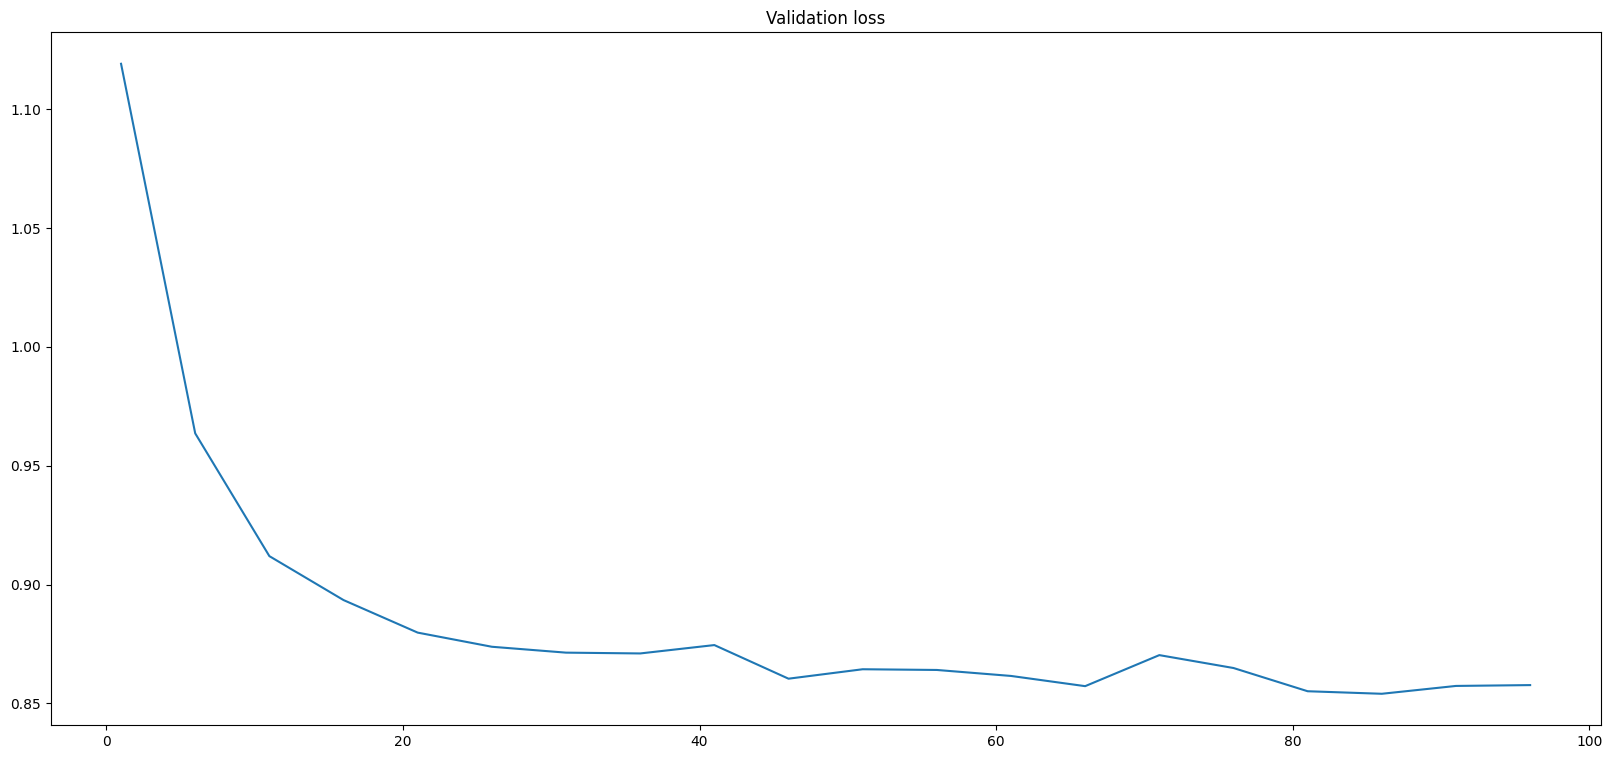

In [28]:
import time

check_factors = range(1, 100, 5)
subset_records = 1000000
bs = 20000
losses = {}
times = {}
epochs = 5
lr = 0.005
wd = 0.1

ch_factor_df = df_ratings.copy().head(subset_records)

for n_factors in check_factors:
    print('====================', n_factors, '====================')
    dls = CollabDataLoaders.from_df(
        ch_factor_df,
        user_name='userId',
        item_name='movieId',
        rating_name='rating',
        bs=bs,
        seed=42
    )
    learn = collab_learner(
        dls,
        n_factors=n_factors,
        y_range=(0, 5.5),
        use_nn=False
    )
    with learn.no_bar(), learn.no_logging():
        start = time.time()

        losses[bs] = learn.validate()
        learn.fit_one_cycle(
            epochs,
            lr,
            wd=wd,
            cbs=EarlyStoppingCallback(patience=2)
        )
        end = time.time()
        losses[n_factors] = learn.validate()
        times[bs] = end - start

losses = pd.DataFrame.from_dict(losses, orient='index')

Text(0, 0.5, 'Error rate')

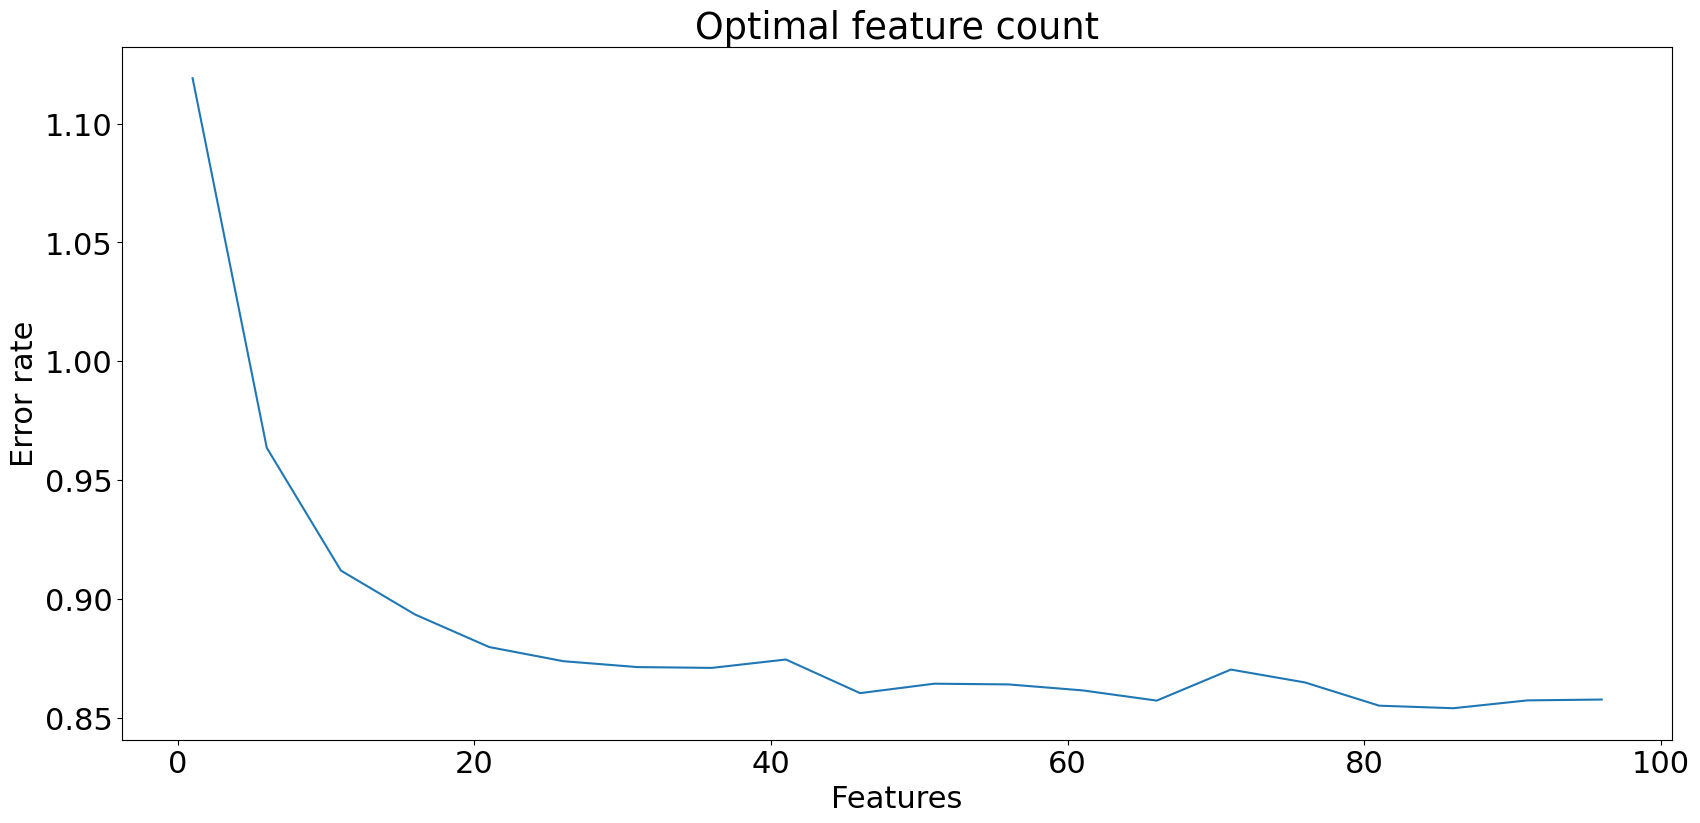

In [31]:
# increace font size
plt.rcParams.update({'font.size': 22})
losses.plot(title='Optimal feature count', legend=False)
# set x axis title
plt.xlabel('Features')
# set y axis title
plt.ylabel('Error rate')

# Finding optimal batch size

In [107]:
import time
from fastai.learner import Recorder

check_batch_sizes = [2**x for x in range(10, 18)]
subset_records = 1000000
n_factors = 20
losses = {}
times = {}
epochs = 5
lr = 0.001
wd = 0.1

ch_batch_df = df_ratings.copy().head(subset_records)

for bs in check_batch_sizes:
    print('====================', bs, '====================')
    dls = CollabDataLoaders.from_df(
        ch_batch_df,
        user_name='userId',
        item_name='movieId',
        rating_name='rating',
        bs=bs,
        seed=42
    )
    learn = collab_learner(
        dls,
        n_factors=n_factors,
        y_range=(0, 5.5),
        use_nn=False
    )
    # enable recorder
    # learn.recorder = Recorder(learn)
    start = time.time()
    with learn.no_bar(), learn.no_logging():
        learn.fit_one_cycle(
            epochs,
            lr,
            wd=wd,
            cbs=EarlyStoppingCallback(patience=2)
        )
    end = time.time()
    losses[bs] = learn.validate()
    times[bs] = end - start

losses = pd.DataFrame.from_dict(losses, orient='index')
times = pd.DataFrame.from_dict(times, orient='index')

==================== 1024 ====================
No improvement since epoch 2: early stopping


==================== 2048 ====================


==================== 4096 ====================


==================== 8192 ====================


==================== 16384 ====================


==================== 32768 ====================


==================== 65536 ====================


==================== 131072 ====================


Text(0, 0.5, 'Error rate')

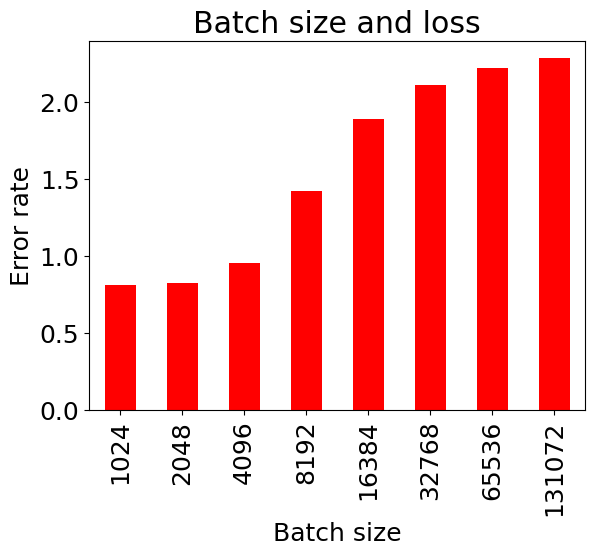

In [115]:
plt.rcParams.update({'font.size': 18})
losses.plot(title='Batch size and loss', legend=False, kind='bar', color='red')
# set x axis title
plt.xlabel('Batch size')
# set y axis title
plt.ylabel('Error rate')

Text(0, 0.5, 'Training time')

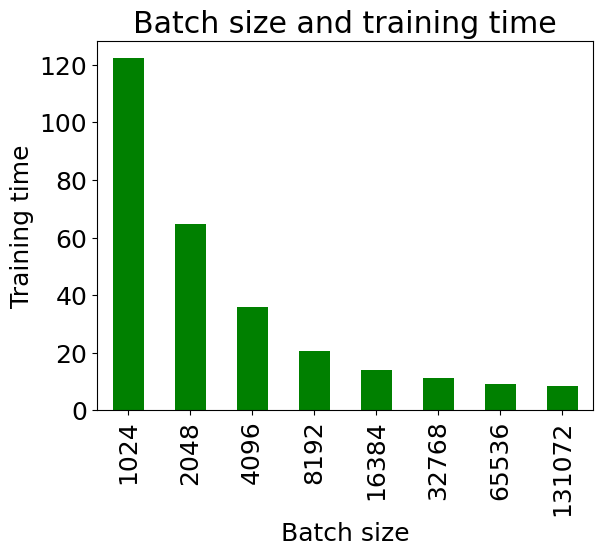

In [114]:
plt.rcParams.update({'font.size': 18})
times.plot(title='Batch size and training time', legend=False, kind='bar', color='green')
# set x axis title
plt.xlabel('Batch size')
# set y axis title
plt.ylabel('Training time')

Judging by results, batch size of 4096 is optimal

In [54]:
# Finding optimal learning rate

SuggestedLRs(minimum=0.06309573650360108, steep=0.14454397559165955, valley=0.005248074419796467, slide=0.03981071710586548)

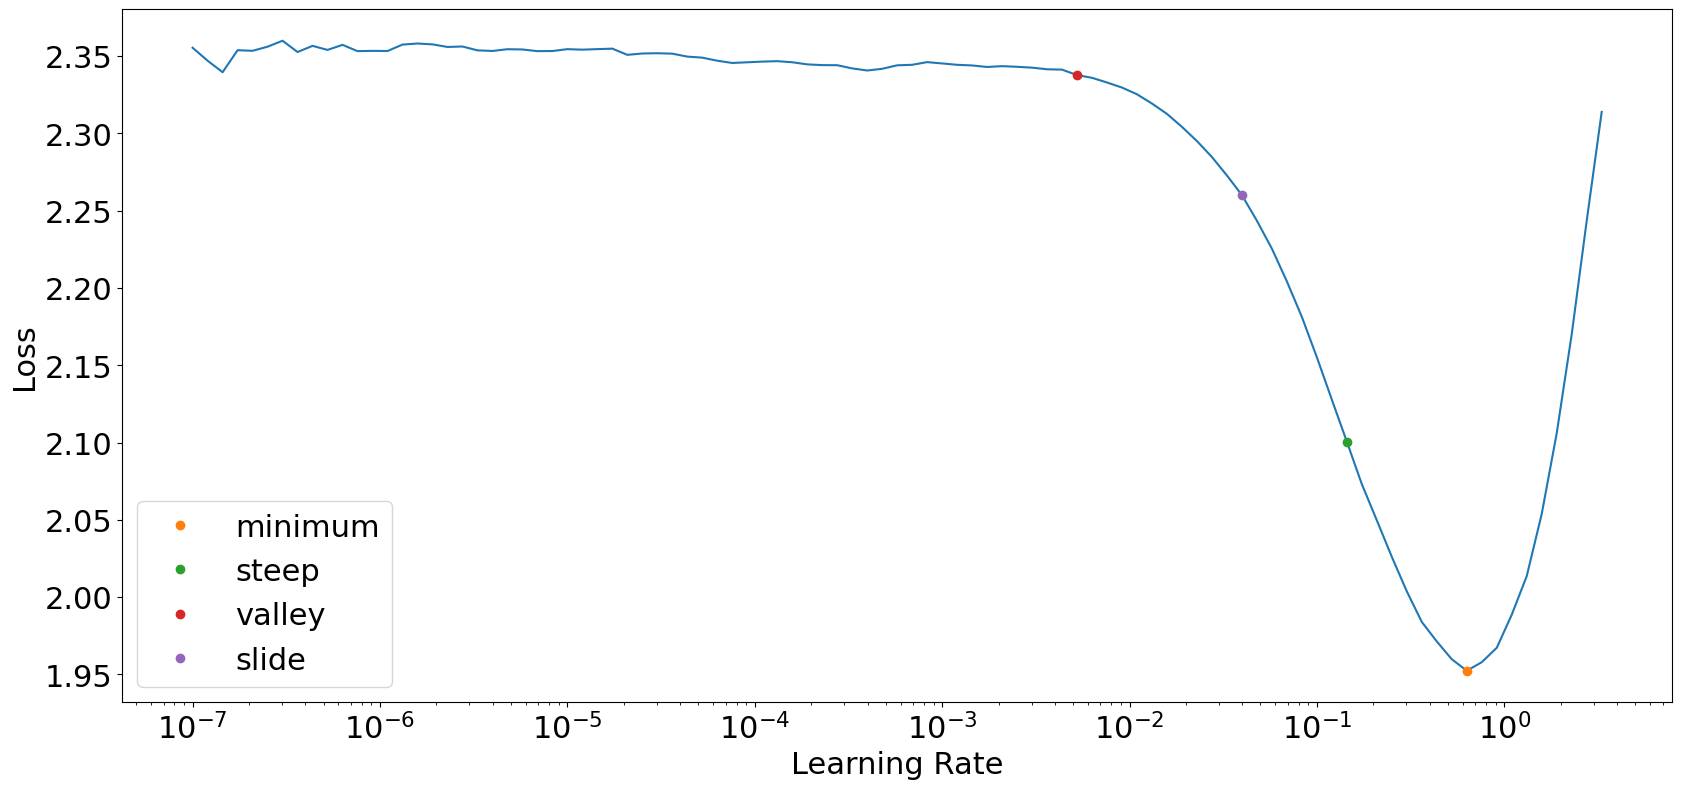

In [59]:
from fastai.callback.schedule import steep, minimum, valley, slide

subset_records = 1000000
n_factors = 20
bs = 4096

ch_lr_df = df_ratings.copy().head(subset_records)

dls = CollabDataLoaders.from_df(
    ch_batch_df,
    user_name='userId',
    item_name='movieId',
    rating_name='rating',
    bs=bs,
    seed=42
)
learn = collab_learner(
    dls,
    n_factors=n_factors,
    y_range=(0, 5.5),
    use_nn=False
)
learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))



In [ ]:
learn.recorder.plot_lr_find()

Optimal learning rate is 0.005

# Train the model using optimal parameters

In [5]:
n_factors = 50
bs = 2048
epochs = 5
lr = 0.005
wd = 0.1

dls = CollabDataLoaders.from_df(
    df_ratings,
    user_name='userId',
    item_name='movieId',
    rating_name='rating',
    bs=bs,
    seed=42
)


In [ ]:

learn = collab_learner(
    dls,
    n_factors=n_factors,
    y_range=(0, 5.5),
    use_nn=False
)

learn.fit_one_cycle(
    epochs,
    lr,
    wd=wd,
    cbs=EarlyStoppingCallback(patience=2)
)

learn.export('models/collab_learner.pkl')

In [ ]:
learn.validate()

# Analyze weights and biases

In [6]:
# load saved model
model_name = 'models/collab_learner.pkl'
learn = load_learner(model_name)

In [7]:
learn.model

EmbeddingDotBias(
  (u_weight): Embedding(162542, 20)
  (i_weight): Embedding(56577, 20)
  (u_bias): Embedding(162542, 1)
  (i_bias): Embedding(56577, 1)
)

##  Worst movies (that you might won't like even if you usually like movies like that)

for each of these movies, even when a user is very well matched to its latent factors (which, as we will see in a moment, tend to represent things like level of action, age of movie, and so forth), they still generally don't like it.

In [23]:
learn.model.i_bias.weight.squeeze()

tensor([4.3748e-04, 5.6331e-01, 1.7381e-01,  ..., 2.5820e-02, 3.1825e-03,
        8.6878e-03], grad_fn=<SqueezeBackward0>)

In [9]:
movie_bias = learn.model.i_bias.weight.squeeze()
idxs = movie_bias.argsort()[:10]
worst_movies = pd.DataFrame([dls.classes['movieId'][i] for i in idxs], columns=['movieId'])
worst_movies = pd.merge(worst_movies, df_movies, on='movieId')
worst_movies

,movieId,title,genres
0,8859,SuperBabies: Baby Geniuses 2 (2004),Comedy
1,4775,Glitter (2001),Drama|Musical|Romance
2,6483,From Justin to Kelly (2003),Musical|Romance
3,61348,Disaster Movie (2008),Comedy
4,31698,Son of the Mask (2005),Adventure|Children|Comedy|Fantasy
5,6587,Gigli (2003),Comedy|Crime|Romance
6,1826,Barney's Great Adventure (1998),Adventure|Children
7,50798,Epic Movie (2007),Adventure|Comedy
8,6371,Pokémon Heroes (2003),Animation|Children
9,6872,"House of the Dead, The (2003)",Action|Horror


## Best movies (that you might like if you usually don't watch movies like that)

In [17]:
idxs = movie_bias.argsort(descending=True)[:40]
best_movies = pd.DataFrame([dls.classes['movieId'][i] for i in idxs], columns=['movieId'])
best_movies = pd.merge(best_movies, df_movies, on='movieId')
pd.set_option('display.max_rows', 40)
display(best_movies[['title', 'genres']])

,title,genres
0,Planet Earth (2006),Documentary
1,"Shawshank Redemption, The (1994)",Crime|Drama
2,Planet Earth II (2016),Documentary
3,Band of Brothers (2001),Action|Drama|War
4,"Usual Suspects, The (1995)",Crime|Mystery|Thriller
5,"Godfather, The (1972)",Crime|Drama
6,Schindler's List (1993),Drama|War
7,12 Angry Men (1957),Drama
8,The Blue Planet (2001),Documentary
9,Blue Planet II (2017),Documentary


## Exploring learned factors using PCA

In [38]:
learn.model.i_weight.weight

Parameter containing:
tensor([[ 8.3818e-04, -1.0587e-04,  7.4872e-04,  ..., -3.3785e-04,
          4.2972e-05,  4.7720e-04],
        [ 1.7623e+00, -5.1383e-01,  3.2773e-01,  ...,  4.6854e-01,
          1.5220e+00,  5.4041e-01],
        [-4.5834e-01,  4.1921e-01,  1.5370e-01,  ...,  7.5989e-01,
          6.8303e-01,  2.5513e-01],
        ...,
        [-6.2915e-03, -1.3161e-02, -8.1322e-03,  ..., -9.1242e-03,
         -1.8698e-03, -8.9558e-03],
        [-2.8806e-04, -2.8855e-05, -6.2820e-04,  ...,  6.9937e-05,
         -2.4289e-05,  8.7912e-05],
        [ 1.0280e-03,  2.2440e-04, -1.8482e-04,  ...,  7.9337e-04,
          6.3211e-04,  2.5539e-04]], requires_grad=True)

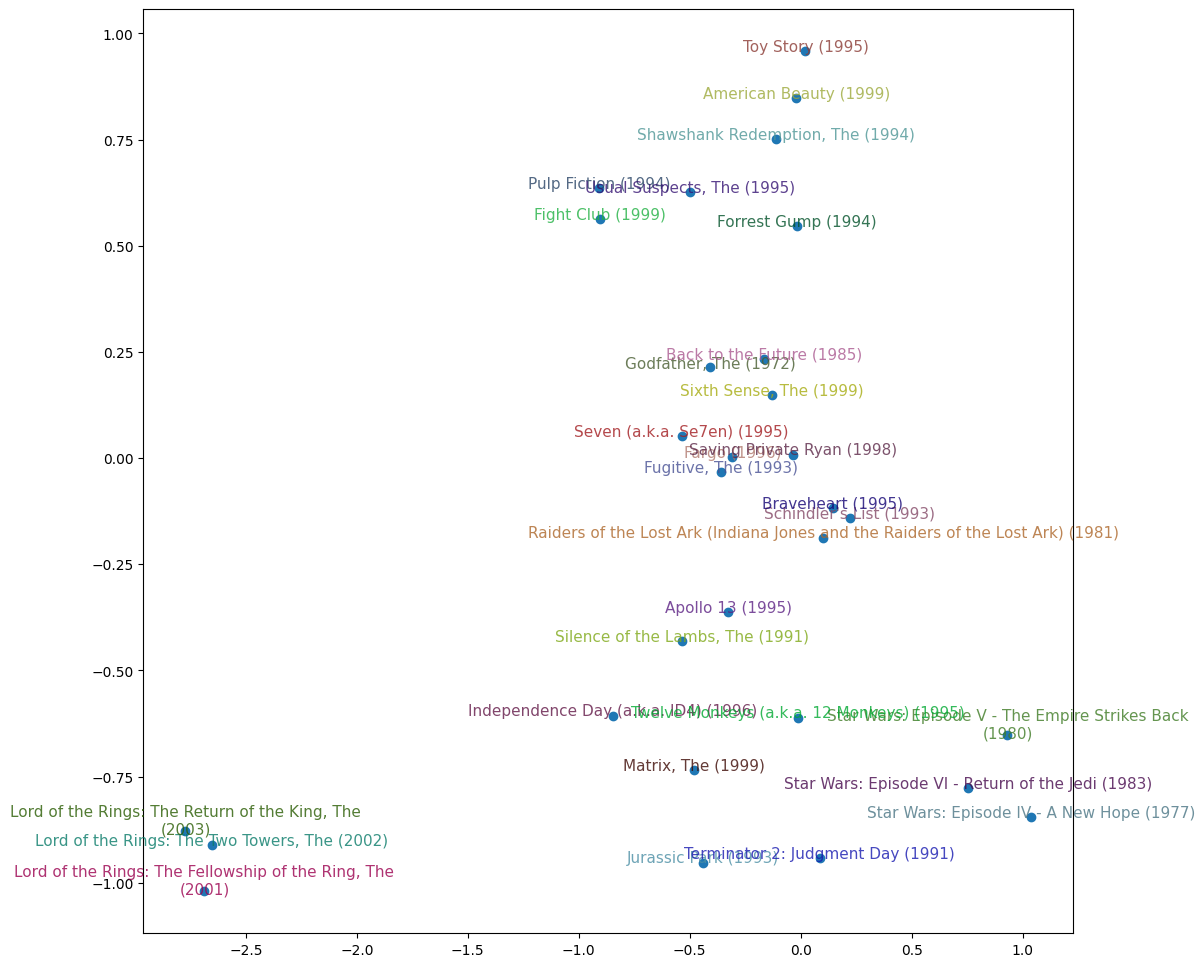

In [34]:

#hide_input
#id img_pca_movie
#caption Representation of movies based on two strongest PCA components
#alt Representation of movies based on two strongest PCA components
g = df_ratings.groupby('movieId')['rating'].count()
top_movies = g.sort_values(ascending=False).index.values[:1000]
top_idxs = tensor([learn.dls.classes['movieId'].o2i[m] for m in top_movies])
movie_w = learn.model.i_weight.weight[top_idxs].cpu().detach()
movie_pca = movie_w.pca(15)
learned_factors = movie_pca.t()
idxs = list(range(30))
fact1 = 12
fact2 = 5
X = learned_factors[fact1][idxs]
Y = learned_factors[fact2][idxs]

plt.figure(figsize=(12,12))
plt.scatter(X, Y)
df_movies_indexed = df_movies.copy()
df_movies_indexed.set_index('movieId', inplace=True)

for i, x, y in zip(top_movies[idxs], X, Y):
    plt.text(x,y,df_movies_indexed.loc[i, 'title'], color=np.random.rand(3)*0.7, fontsize=11, alpha=0.8, wrap=True, ha='center')
plt.show()

## Embedding distance

On a two-dimensional map we can calculate the distance between two coordinates using the formula of Pythagoras: √x2+y2 (assuming that x and y are the distances between the coordinates on each axis). For a 50-dimensional embedding we can do exactly the same thing, except that we add up the squares of all 50 of the coordinate distances.

In [132]:
from torch import nn

required_movie_title = 'Star Wars: Episode IV - A New Hope (1977)'
required_movie_id = df_movies_indexed[df_movies_indexed['title'] == required_movie_title].index[0]

movie_factors = learn.model.i_weight.weight

idx = dls.classes['movieId'].o2i[required_movie_id]

distances = nn.CosineSimilarity(dim=1)(movie_factors, movie_factors[idx][None])
idx = distances.argsort(descending=True)[:11]

for movieId in dls.classes['movieId'][idx]:
    print(df_movies_indexed.loc[movieId, 'title'])

Star Wars: Episode IV - A New Hope (1977)
Star Wars: Episode V - The Empire Strikes Back (1980)
Star Wars: Episode VI - Return of the Jedi (1983)
Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981)
Star Wars: Episode VII - The Force Awakens (2015)
Pecos River (1951)
Indiana Jones and the Last Crusade (1989)
Demon Witch Child (1975)
Tunisian Victory (1944)
Rogue One: A Star Wars Story (2016)
Mara und der Feuerbringer (2015)


# Making predictions for user

In [116]:
test_user_id = 1
test_df = df_movies.copy()
test_df = pd.merge(
    pd.DataFrame([test_user_id]*len(test_df), columns=['userId']),
    test_df,
    left_index=True,
    right_index=True
)
test_df = test_df.reset_index(drop=True)
test_df.shape

(62423, 4)

In [117]:
bs = 8192
test_dl = learn.dls.test_dl(
    test_df,
    bs=bs,
    user_name='userId',
    item_name='movieId'
)
test_dl.show_batch()

,userId,movieId
0,1,1
1,1,2
2,1,3
3,1,4
4,1,5
5,1,6
6,1,7
7,1,8
8,1,9
9,1,10


In [118]:
preds, _ = learn.get_preds(dl=test_dl)
preds.shape

torch.Size([62423])

In [119]:

preds_df = pd.merge(
    test_df,
    pd.DataFrame(preds, columns=['rating']),
    left_index=True,
    right_index=True
)
display(preds_df)

,userId,movieId,title,genres,rating
0,1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,3.629956
1,1,2,Jumanji (1995),Adventure|Children|Fantasy,2.899283
2,1,3,Grumpier Old Men (1995),Comedy|Romance,2.807442
3,1,4,Waiting to Exhale (1995),Comedy|Drama|Romance,2.726276
4,1,5,Father of the Bride Part II (1995),Comedy,2.592977
...,...,...,...,...,...
62418,1,209157,We (2018),Drama,2.898869
62419,1,209159,Window of the Soul (2001),Documentary,2.946213
62420,1,209163,Bad Poems (2018),Comedy|Drama,2.978620
62421,1,209169,A Girl Thing (2001),(no genres listed),2.949955


In [120]:
# users past ratings
user_past_ratings = df_ratings[(df_ratings['userId'] == test_user_id) & (df_ratings['rating'] == 5)]
user_past_ratings = user_past_ratings.sort_values(by=['rating'], ascending=False)
display(user_past_ratings)

,userId,movieId,rating,title,genres
0,1,296,5.0,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller
306012,1,4325,5.0,"Night, The (Notte, La) (1960)",Drama
569215,1,8327,5.0,Dolls (2002),Drama|Romance
567528,1,8154,5.0,"Dolce Vita, La (1960)",Drama
529695,1,7361,5.0,Eternal Sunshine of the Spotless Mind (2004),Drama|Romance|Sci-Fi
494672,1,6711,5.0,Lost in Translation (2003),Comedy|Drama|Romance
401619,1,6016,5.0,City of God (Cidade de Deus) (2002),Action|Adventure|Crime|Drama|Thriller
346525,1,5767,5.0,Teddy Bear (Mis) (1981),Comedy|Crime
288949,1,4144,5.0,In the Mood For Love (Fa yeung nin wa) (2000),Drama|Romance
86730,1,307,5.0,Three Colors: Blue (Trois couleurs: Bleu) (1993),Drama


In [121]:
# merge actual user ratings with predicted values
preds_eval_df = pd.merge(
    preds_df[['movieId', 'rating']],
    user_past_ratings[['movieId', 'rating']],
    on='movieId',
    how='inner',
    suffixes=['_pred', '_actual']
)
display(preds_eval_df)

,movieId,rating_pred,rating_actual
0,296,4.787445,5.0
1,307,4.170053,5.0
2,665,4.103725,5.0
3,1237,4.071089,5.0
4,2632,3.580012,5.0
5,2692,4.305584,5.0
6,3569,3.610667,5.0
7,3949,4.334266,5.0
8,4144,4.116405,5.0
9,4325,3.765133,5.0


In [122]:
top_preds = preds_df.sort_values(by=['rating'], ascending=False)[:30]
display(top_preds)

,userId,movieId,title,genres,rating
292,1,296,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller,4.787445
2867,1,2959,Fight Club (1999),Action|Crime|Drama|Thriller,4.620254
4867,1,4973,"Amelie (Fabuleux destin d'Amélie Poulain, Le) (2001)",Comedy|Romance,4.612640
2766,1,2858,American Beauty (1999),Drama|Romance,4.608147
49,1,50,"Usual Suspects, The (1995)",Crime|Mystery|Thriller,4.547767
7236,1,7361,Eternal Sunshine of the Spotless Mind (2004),Drama|Romance|Sci-Fi,4.500516
762,1,778,Trainspotting (1996),Comedy|Crime|Drama,4.462372
314,1,318,"Shawshank Redemption, The (1994)",Crime|Drama,4.422723
40597,1,159817,Planet Earth (2006),Documentary,4.415276
4122,1,4226,Memento (2000),Mystery|Thriller,4.411974


In [123]:
bottom_preds = preds_df.sort_values(by=['rating'], ascending=True)[:10]
display(bottom_preds)

,userId,movieId,title,genres,rating
4669,1,4775,Glitter (2001),Drama|Musical|Romance,1.326093
8144,1,8859,SuperBabies: Baby Geniuses 2 (2004),Comedy,1.338053
6360,1,6483,From Justin to Kelly (2003),Musical|Romance,1.367615
9605,1,31698,Son of the Mask (2005),Adventure|Children|Comedy|Fantasy,1.409999
12618,1,61348,Disaster Movie (2008),Comedy,1.441880
1740,1,1826,Barney's Great Adventure (1998),Adventure|Children,1.505597
11351,1,50798,Epic Movie (2007),Adventure|Comedy,1.513947
6464,1,6587,Gigli (2003),Comedy|Crime|Romance,1.514970
3494,1,3593,Battlefield Earth (2000),Action|Sci-Fi,1.556435
6253,1,6371,Pokémon Heroes (2003),Animation|Children,1.577128


# Training NN model

In [95]:
from fastai.tabular.model import get_emb_sz

get_emb_sz(dls)

[(162542, 600), (56577, 600)]

In [84]:
df = pd.DataFrame(np.arange(16).reshape(4, 4), \
                  columns = ['one', 'two', 'three', 'four'], \
                  index = ['北海道', 'colorado', 'utah', 'arizona'])
# use to_string to display as table
df.to_string(col_space=10)

'                  one        two      three       four\n北海道                 0          1          2          3\ncolorado            4          5          6          7\nutah                8          9         10         11\narizona            12         13         14         15'